# Similarity calculation

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

## Dataset Preprocessing (Paula's part)

Load the dataset that Raquel processed (joining a few different datasets and adding the sentiment analysis)

In [22]:
main_complete = pd.read_csv('data/main_complete.csv')
main_complete_og = main_complete.copy()
main_complete.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,music_composer,imdb_rating,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,NaN,7.4,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,NaN,7.5,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Combustible Edison,6.7,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,Alan Silvestri,6.6,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,NaN,8.2,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44


To calculate the similarity, we need to do minhashing, that is why, a tokenization is first needed. We wanted to take several features for calculating the jaccard similarity:
- genre
- cast
- crew
- sentiment
- platforms (one-hot encoded)
- crew
- production companies
- production countries
- imbd votes
- imbd rating

To tokenize the features, we created sets for each of them with all the strings of each category inside

### Genres

In [23]:
# check how many movies have no genre
nulls = main_complete['genres'].isnull().sum()
print("This percentage of movies have no genre:", nulls/len(main_complete)*100, "%")

This percentage of movies have no genre: 29.076318106153554 %


In [24]:
# split the genres into a set of genres and remove spaces
main_complete['genres'] = main_complete['genres'].apply(lambda x: set(genre.strip() for genre in x.split(',')) if pd.notnull(x) else set())

We also did a small analysis of the genres to know with what we were working with

There are  19 different genres in the dataset
The genres are: {'Thriller', 'Music', 'Documentary', 'Crime', 'Adventure', 'Horror', 'Mystery', 'Fantasy', 'Western', 'History', 'Family', 'Action', 'Drama', 'Science Fiction', 'Animation', 'Comedy', 'Romance', 'War', 'TV Movie'}


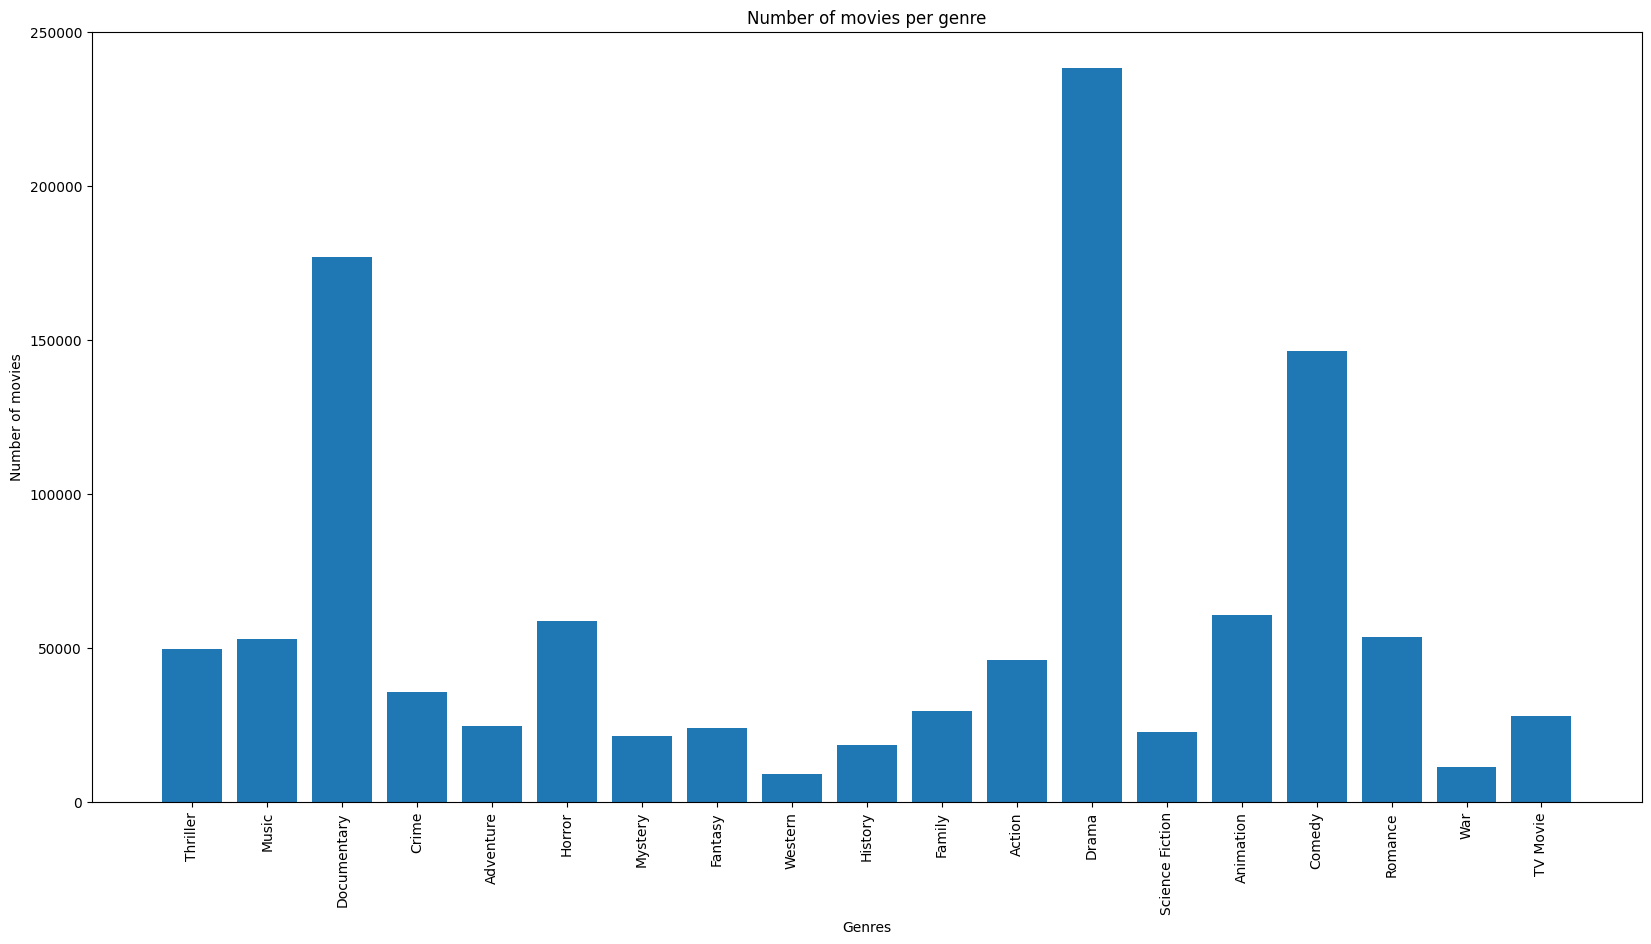

In [25]:
# check how many different genres are taking into account the content of the lists
genres = set()
for list in main_complete['genres']:
    # if list is not NaN
    if list is not np.nan:
        for genre in list:
            # remove the space at the beginning of the string if there is one
            genre = genre.strip()
            genres.add(genre)
print("There are ", len(genres), "different genres in the dataset")
print("The genres are:", genres)

genres_count = {genre: 0 for genre in genres}
for genre_list in main_complete['genres']:
    if genre_list is not np.nan:
        for genre in genre_list:
            genre = genre.strip()
            genres_count[genre] += 1

# histogram
plt.figure(figsize=(20, 10))
plt.bar(genres_count.keys(), genres_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.show()

### Cast and crew

We reproduced the same procedure that we did for the genres. In this case, for the crew, we joined the columns of director and producers.

In [26]:
# split the cast into a set of cast and remove spaces
main_complete['cast'] = main_complete['cast'].apply(lambda x: set(actor.strip() for actor in x.split(',')) if pd.notnull(x) else set())

In [27]:
# how many movies have no cast
nulls = main_complete['cast'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no cast:", nulls/len(main_complete)*100, "%")

print(nulls)

This percentage of movies have no cast: 33.29124741666741 %
336188


After doing several tests with the code using different features, we decided to discard the 'cast' one because, since it is long, it has a big weight when calculating the similarities.

In [28]:
# remove the cast column
main_complete = main_complete.drop(columns=['cast'])

In [29]:
# Join the director and producers columns into a single column crew
columns_to_merge = ['director', 'producers']

for column in columns_to_merge:
    main_complete[column] = main_complete[column].apply(lambda x: set(person.strip() for person in x.split(',')) if pd.notnull(x) else set())

main_complete['crew'] = main_complete.apply(lambda row: set.union(row['director'], row['producers']), axis=1)

# Drop the individual columns
main_complete.drop(columns=columns_to_merge, inplace=True)

In [30]:
# how many movies have no crew
nulls = main_complete['crew'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no crew:", nulls/len(main_complete)*100, "%")

This percentage of movies have no crew: 17.2818637426362 %


### Production companies and countries

The same procedure was followed with these two features

In [31]:
# split the production_companies into a set and remove spaces
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: set(company.strip() for company in x.split(',')) if pd.notnull(x) else set())
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: x - {''})

In [32]:
# percentage of movies with no production companies
nulls = main_complete['production_companies'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production companies:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production companies: 53.91235632610743 %


In [33]:
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: set(country.strip() for country in x.split(',')) if pd.notnull(x) else set())
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: x - {''})

In [34]:
# percentage of movies with no production countries
nulls = main_complete['production_countries'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production countries:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production countries: 39.518774774988884 %


### Sentiment analysis

After calculating the sentiment for each movie, to take it into account for the minhashing, we decided to create three categories depending on the values. This was done due to the fact that dor this method, integers don't work as good as strings (TO REVIEW).

To find the thresholds we ...

In [35]:
sentiment_min = main_complete['sentiment'].min()
sentiment_max = main_complete['sentiment'].max()
sentiment_mean = main_complete['sentiment'].mean()
sentiment_std = main_complete['sentiment'].std()
sentiment_mid = main_complete['sentiment'].median()

print(f"Range of sentiment values: {sentiment_min} to {sentiment_max} with mean {sentiment_mean} and standard deviation {sentiment_std} and median {sentiment_mid}")

Range of sentiment values: 0.0 to 621.52 with mean 109.39746533773106 and standard deviation 83.97651422418457 and median 85.76


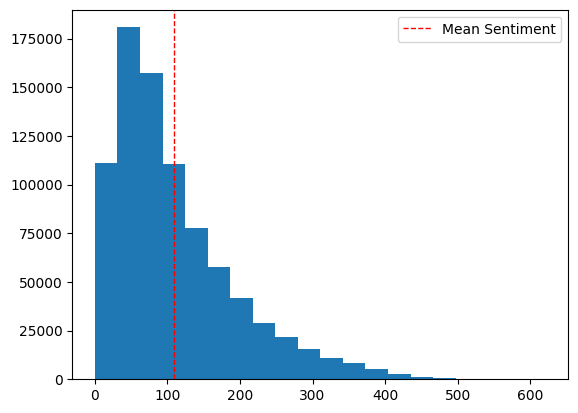

In [36]:
plt.hist(main_complete['sentiment'], bins=20)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.legend()
plt.show()

In [37]:
# Define the thresholds for sentiment ranges
low_threshold = sentiment_mean - sentiment_std
high_threshold = sentiment_mean + sentiment_std

# Function to categorize sentiment
def categorize_sentiment(value):
    if value < low_threshold:
        return 'low'
    elif value > high_threshold:
        return 'high'
    else:
        return 'medium'

# Assuming main_complete is already defined and categorize_sentiment is a function
main_complete.loc[:, 'sentiment_category'] = main_complete['sentiment'].apply(categorize_sentiment)

# Display the updated dataframe
main_complete[['title', 'sentiment', 'sentiment_category']].head()

,title,sentiment,sentiment_category
0,Ariel,68.24,medium
1,Shadows in Paradise,73.44,medium
2,Four Rooms,86.06,medium
3,Judgment Night,79.34,medium
4,Life in Loops (A Megacities RMX),382.44,high


### Dataset cleaning

Finally, before doing the minhashing, some movies were deleted from the dataset because they had more than 4 interested features empty and because they were not "Released".

In [38]:
# clean movies with 3 or more interesting columns empty
columns = ['genres', 'crew', 'production_companies', 'production_countries', 'sentiment_category']

initial_count = len(main_complete)

# check each row if they have 3 or more columns from columns with empty sets
main_complete = main_complete[~(main_complete[columns].apply(lambda x: sum(1 for i in x if len(i) == 0) >= 4, axis=1))]
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  94569 from a total of  1009839
Percentage of movies removed:  9.364760125128857 %


In [39]:
# remove movies if the 'status' is not 'Released'
initial_count = len(main_complete)
main_complete = main_complete[main_complete['status'] == 'Released']
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  15995 from a total of  915270
Percentage of movies removed:  1.7475717547827416 %


Finally we saved the processed dataset so that we didn't have to run all the code everytime

## Minhashing

Load the small dataset that is the result of all the previous steps NOT SURE!!!
For some reason, when the dataset is loaded, the tokenization is lost and the similarity is not well calculated.

In [40]:
# prepare data for the minhashing, i just want to keep the columns: title, genre ones, sentiment, cast, crew, production_companies, production_countries and platform ones
data = main_complete[['id', 'title', 'genres', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO', 'crew', 'production_companies', 'production_countries', 'imdb_votes', 'imdb_rating']]

In [41]:
# data = main_complete.copy()

In [42]:
# load the small dataset
# data2 = pd.read_csv('data/small_main_complete.csv')

In [43]:
data.head()

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating
0,2,Ariel,"{Crime, Comedy, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4
1,3,Shadows in Paradise,"{Comedy, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Lawrence Bender, Quentin Tarantino, Alexandre...","{Miramax, A Band Apart}",{United States of America},112484.0,6.7
3,6,Judgment Night,"{Action, Crime, Thriller}",medium,0.0,1.0,0.0,0.0,0.0,"{Lloyd Segan, Gene Levy, Marilyn Vance, Stephe...","{Universal Pictures, Largo Entertainment, JVC}",{United States of America},19268.0,6.6
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Timo Novotny, Ulrich Gehmacher}",{inLoops},{Austria},284.0,8.2


Create the minhashes for each row

In [44]:
# data2.head()

In [45]:
# Function to create a combined MinHash for a movie
def create_combined_minhash(movie, one_hot_features, non_one_hot_features, num_perm=128):
    m = MinHash(num_perm=num_perm)
    
    # Add one-hot encoded features
    for feature in one_hot_features:
        if movie[feature] == 1:
            m.update(feature.encode('utf8'))
    
    # Add non-one-hot encoded features
    for feature in non_one_hot_features:
        for token in movie[feature]:
            m.update(token.encode('utf8'))
    
    return m

In [46]:
# list of one-hot encoded features
one_hot_features = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

# list of non-one-hot encoded features
non_one_hot_features = ['genres', 'sentiment_category', 'crew', 'production_companies', 'production_countries']

We create the minhashes taking into account the desired features

In [47]:
minhashes = []
for idx, movie in tqdm(data.iterrows(), total=len(data), desc="Creating MinHashes"):
    minhash = create_combined_minhash(movie, one_hot_features, non_one_hot_features)
    minhashes.append(minhash)

Creating MinHashes: 100%|██████████| 899275/899275 [06:06<00:00, 2454.04it/s]


In [48]:
data['minhash'] = minhashes
data.head()

/var/folders/x1/r0lcq37s2gv_b_dbmtl4lrx40000gn/T/ipykernel_3638/3287800951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minhash'] = minhashes


,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
0,2,Ariel,"{Crime, Comedy, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4,<datasketch.minhash.MinHash object at 0x43e4b1...
1,3,Shadows in Paradise,"{Comedy, Romance, Drama}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5,<datasketch.minhash.MinHash object at 0x3c6edc...
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Lawrence Bender, Quentin Tarantino, Alexandre...","{Miramax, A Band Apart}",{United States of America},112484.0,6.7,<datasketch.minhash.MinHash object at 0x367f14...
3,6,Judgment Night,"{Action, Crime, Thriller}",medium,0.0,1.0,0.0,0.0,0.0,"{Lloyd Segan, Gene Levy, Marilyn Vance, Stephe...","{Universal Pictures, Largo Entertainment, JVC}",{United States of America},19268.0,6.6,<datasketch.minhash.MinHash object at 0x357d47...
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Timo Novotny, Ulrich Gehmacher}",{inLoops},{Austria},284.0,8.2,<datasketch.minhash.MinHash object at 0x357d47...


In order to be computational efficient, a function that interacts with the user is created so that the program calculates the jaccard similarity of all the movies with the one inputed by the user. The result of this function is a list of the 10th more similar movies.

In [49]:
def estimate_jaccard_similarity(data, minhashes, movie_title):
    # Find all movies with the specified title
    matching_movies = data[data['title'] == movie_title]

    if len(matching_movies) > 1:
        print(f"There are multiple movies with the title '{movie_title}'. Please choose one by its id:")
        for idx, row in matching_movies.iterrows():
            print(f"ID: {row['id']}, Crew: {row['crew']}")
        movie_id = int(input("Enter the movie id: "))
        movie_index = data[data['id'] == movie_id].index[0]
        print(f"Selected movie with id '{movie_id}' in position '{movie_index}'")
    elif len(matching_movies) == 1:
        movie_index = data[data['title'] == movie_title].index[0]
        print('movie_index:', movie_index)
        movie_id = data[data['title'] == movie_title]['id'].values[0]
        print(f"movie_id: {movie_id}")
    else:
        print(f"No movies found with the title '{movie_title}'")
        return []

    # Estimate Jaccard similarity with the specified movie
    print(f"Estimated Jaccard Similarity with '{movie_title}':")
    similarity_scores = []

    for i in tqdm(range(len(minhashes)), desc="Calculating Similarities"):
        if i != movie_index:
            similarity = data.iloc[movie_index]['minhash'].jaccard(data.iloc[i]['minhash'])
            similarity_scores.append((data.iloc[i]['title'], similarity, minhashes[i], data.iloc[i]['id']))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    return similarity_scores, movie_id

In [50]:
# ask the user to input a movie title
movie_title = input("Enter a movie title: ")

print('The movie title that you entered is:', movie_title)
# estimate the Jaccard similarity with the specified movie
similarity_scores, movie_id = estimate_jaccard_similarity(data, minhashes, movie_title)
print(movie_id)

The movie title that you entered is: Harry Potter and the Philosopher's Stone
movie_index: 541
movie_id: 671
Estimated Jaccard Similarity with 'Harry Potter and the Philosopher's Stone':


Calculating Similarities: 100%|██████████| 899275/899275 [01:09<00:00, 12868.38it/s]


671


In [51]:
similarity_scores[:10]

[('Harry Potter and the Chamber of Secrets',
  0.71875,
  np.int64(672)),
 ('Harry Potter and the Prisoner of Azkaban',
  0.6171875,
  np.int64(673)),
 ("Harry Potter and the Philosopher's Stone (Extended)",
  0.5703125,
  np.int64(1290195)),
 ('Monkeybone',
  0.5546875,
  np.int64(23685)),
 ('Night at the Museum',
  0.4921875,
  np.int64(1593)),
 ('The Christmas Chronicles',
  0.484375,
  np.int64(527435)),
 ('Night at the Museum: Kahmunrah Rises Again',
  0.4765625,
  np.int64(751741)),
 ('Percy Jackson & the Olympians: The Lightning Thief',
  0.46875,
  np.int64(32657)),
 ('Percy Jackson: Sea of Monsters',
  0.46875,
  np.int64(76285)),
 ('Valley of the Giants',
  0.46875,
  np.int64(174767))]

In [52]:
# Function to create a DataFrame with the top N similar movies
def create_top_n_dataframe(similarity_scores, data, movie_id, n=10):
    columns = ['title', 'crew', 'production_companies', 'production_countries', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']
    top_n_df = pd.DataFrame(columns=columns)
    top_n_list = []
    
    for movie, score, minhash, id in similarity_scores[:n]:
        movie_data = data[data['id'] == id]
        top_n_list.append(movie_data)

    top_n_list.append(data[data['id'] == movie_id])
    top_n_df = pd.concat(top_n_list)
    
    return top_n_df

# Create the DataFrame with the top 10 similar movies
top_10_df = create_top_n_dataframe(similarity_scores, data, movie_id, n=10)
top_10_df

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
542,672,Harry Potter and the Chamber of Secrets,"{Fantasy, Adventure}",medium,1.0,1.0,1.0,0.0,1.0,"{David Heyman, Mark Radcliffe, David Barron, M...","{Warner Bros. Pictures, Heyday Films, 1492 Pic...","{United Kingdom, United States of America}",707984.0,7.4,<datasketch.minhash.MinHash object at 0x445bda...
543,673,Harry Potter and the Prisoner of Azkaban,"{Fantasy, Adventure}",medium,1.0,1.0,1.0,0.0,1.0,"{David Heyman, Alfonso Cuarón, Mark Radcliffe,...","{Warner Bros. Pictures, Heyday Films, P of A P...","{United Kingdom, United States of America}",708032.0,7.9,<datasketch.minhash.MinHash object at 0x445bda...
933332,1290195,Harry Potter and the Philosopher's Stone (Exte...,"{Fantasy, Adventure}",medium,0.0,0.0,0.0,0.0,0.0,{},"{Warner Bros. Pictures, Heydey Films, 1492 Pic...","{United States of America, United Kingdom}",NaN,NaN,<datasketch.minhash.MinHash object at 0x4d38b4...
14003,23685,Monkeybone,"{Adventure, Science Fiction, Fantasy, Animatio...",medium,0.0,0.0,0.0,0.0,0.0,"{Mark Radcliffe, Henry Selick, Michael Barnath...","{Twitching Image Studio, 20th Century Fox, 149...",{United States of America},19448.0,4.8,<datasketch.minhash.MinHash object at 0x173d16...
1042,1593,Night at the Museum,"{Adventure, Family, Comedy, Action, Fantasy}",medium,0.0,0.0,1.0,0.0,0.0,"{Mark Radcliffe, Michael Barnathan, Shawn Levy...","{21 Laps Entertainment, Ingenious Media, 20th ...","{United States of America, United Kingdom}",385061.0,6.5,<datasketch.minhash.MinHash object at 0x338495...
367640,527435,The Christmas Chronicles,"{Fantasy, Comedy, Adventure, Family}",medium,1.0,0.0,0.0,0.0,0.0,"{Mark Radcliffe, David Guggenheim, Michael Bar...","{Madhouse Entertainment, Ocean Blue Entertainm...",{United States of America},84388.0,7.0,<datasketch.minhash.MinHash object at 0x47265a...
535608,751741,Night at the Museum: Kahmunrah Rises Again,"{Fantasy, Comedy, Animation, Family}",medium,0.0,0.0,0.0,0.0,0.0,"{Mark Radcliffe, Emily Morris, Michael Barnath...","{21 Laps Entertainment, Walt Disney Pictures, ...",{United States of America},2685.0,5.0,<datasketch.minhash.MinHash object at 0x495ce8...
20528,32657,Percy Jackson & the Olympians: The Lightning T...,"{Fantasy, Adventure, Family}",medium,1.0,1.0,0.0,0.0,0.0,"{Thomas M. Hammel, Karen Rosenfelt, Guy Oseary...","{Sunswept Entertainment, Dune Entertainment, 1...",{United States of America},206173.0,5.9,<datasketch.minhash.MinHash object at 0x38d3ab...
53668,76285,Percy Jackson: Sea of Monsters,"{Fantasy, Adventure, Family}",medium,1.0,1.0,0.0,0.0,0.0,"{Karen Rosenfelt, Thor Freudenthal, Guy Oseary...","{TSG Entertainment, Sunswept Entertainment, Fo...",{United States of America},128607.0,5.7,<datasketch.minhash.MinHash object at 0x3e7d3f...
104944,174767,Valley of the Giants,{Adventure},medium,0.0,0.0,0.0,0.0,0.0,{William Keighley},{Warner Bros. Pictures},{United States of America},293.0,6.2,<datasketch.minhash.MinHash object at 0x41f5bc...


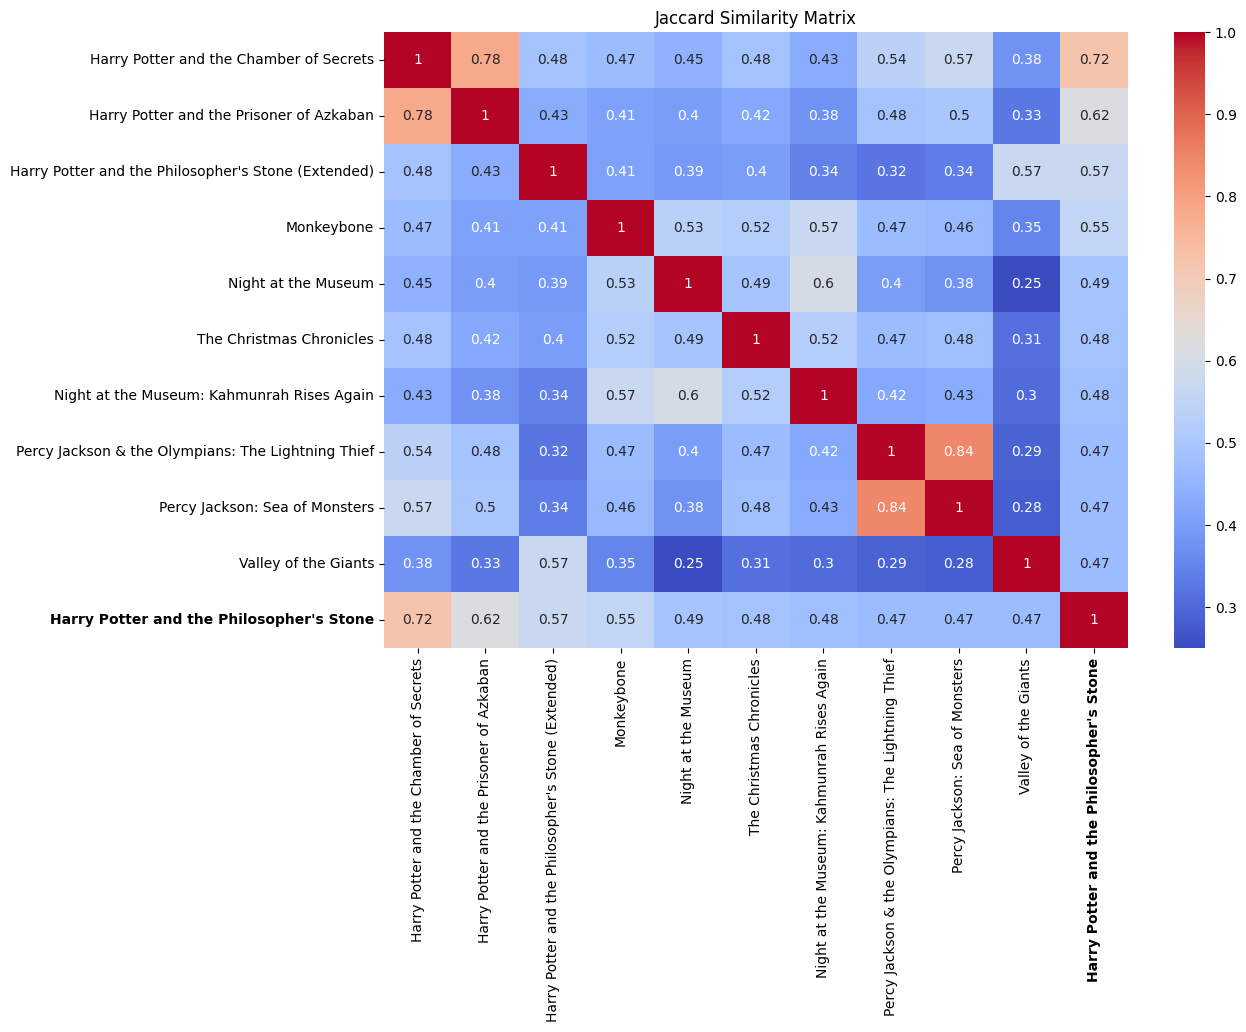

In [57]:
import seaborn as sns

# Function to calculate the Jaccard similarity matrix
def calculate_jaccard_similarity_matrix(top_10_df):
    jaccard_similarity_matrix = np.zeros((len(top_10_df), len(top_10_df)))
    for i in range(len(top_10_df)):
        for j in range(len(top_10_df)):
            jaccard_similarity = top_10_df.iloc[i]['minhash'].jaccard(top_10_df.iloc[j]['minhash'])
            jaccard_similarity_matrix[i][j] = jaccard_similarity
    return jaccard_similarity_matrix

# Calculate the Jaccard similarity matrix
jaccard_similarity_matrix = calculate_jaccard_similarity_matrix(top_10_df)

# Create a heatmap with movie titles
plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_similarity_matrix, annot=True, cmap='coolwarm', xticklabels=top_10_df['title'], yticklabels=top_10_df['title'])
plt.title('Jaccard Similarity Matrix')
# plt.xlabel('Movies')
# plt.ylabel('Movies')
# Get the current axes
ax = plt.gca()

# Get the x and y labels
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

# Make the "Harry Potter and the Philosopher's Stone" label bold on both x and y axis
for i, label in enumerate(xticklabels):
    if label.get_text() == movie_title:
        label.set_fontweight('bold')

for i, label in enumerate(yticklabels):
    if label.get_text() == movie_title:
        label.set_fontweight('bold')

# Apply the updated labels
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.show()
